In [22]:
# Base import and functions

import imutils
import cv2
from imutils import contours

from tqdm import tqdm

import pytesseract             # Python interface to tesseract for OCR

import numpy as np
from PIL import Image

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%load_ext line_profiler


def appendROICnts(
    ROISizedCnts, 
    baseIndex, 
    ROICnts, 
    UsedROICandidate, 
    groupCount, 
    iterations, 
    x, y, w, h, 
    dimension):

    ROICntsCandidate = []
    compareIndex = 0
    for compC in ROISizedCnts:
        # already used
        if (compareIndex in UsedROICandidate):
            compareIndex += 1
            continue

        iterations += 1
        (cx, cy, cw, ch) = cv2.boundingRect(compC)
        # Contours are close and same enought
        if (((abs(x - cx) < 15) and (abs((x + w) - (cx + cw)) < 15) and (abs(w - cw) < 15) and (dimension == 'x')) or 
           ((abs(y - cy) < 15) and (abs((y + h) - (cy + ch)) < 15) and (abs(h - ch) < 15) and (dimension == 'y'))):
            ROICntsCandidate.append(compareIndex)
        
        compareIndex += 1
    
    if (len(ROICntsCandidate) > 8):  # 9 digits
        groupROICnts = []
        for index in ROICntsCandidate:  # add to ROI
            iterations += 1
            groupROICnts.append(ROISizedCnts[index])
            if (index != baseIndex):
                UsedROICandidate.append(index)  # remove trash from base array
            else:
                if (dimension == 'y'):
                    UsedROICandidate.append(index)
        groupCount += 1
        if (dimension == 'x'):
            ROICnts.append({ 'orientation': 'vertical', 'contours': contours.sort_contours(groupROICnts, method="bottom-to-top")[0] })
        if (dimension == 'y'):
            ROICnts.append({ 'orientation': 'horisontal', 'contours': contours.sort_contours(groupROICnts, method="left-to-right")[0] })
                    
    return ROICnts, UsedROICandidate, groupCount, iterations


def excise_segmentation(image):
    %%time
    
    resized = imutils.resize(excise_src, height=500)
    
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    equ = cv2.equalizeHist(gray)
    blurred = cv2.GaussianBlur(equ, (3, 3), 0)
    _, thresholded = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
 
    # return the segmentationed image
    return resized, equ, thresholded


def select_contours(thresholded):
    
    refCnts = cv2.findContours(cv2.Canny(thresholded, 30, 200).copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
    
    width, height = thresholded.shape[:2]
    ROISizedCnts = []
    ROICnts = []
    iterations = 0

    # size filter
    for c in refCnts:
        iterations += 1
        (x, y, w, h) = cv2.boundingRect(c)
        if ((w < width / 9) and (h < height / 9 ) and (w > 7) and (h > 7)):  # 9 digits in serial must be on image
            ROISizedCnts.append(c)

    # positionin filter
    UsedROICandidate = []
    baseIndex = 0
    groupCount = 0
    for c in ROISizedCnts:  
        # already used
        if (baseIndex in UsedROICandidate): 
            baseIndex += 1
            continue

        iterations += 1       
        (x, y, w, h) = cv2.boundingRect(c)   

        # Compare for x dimension
        ROICnts, UsedROICandidate, groupCount, iterations = appendROICnts(
            ROISizedCnts, 
            baseIndex, 
            ROICnts, 
            UsedROICandidate, 
            groupCount, 
            iterations, 
            x, y, w, h, 'x'
        )

        # Compare for y dimension
        ROICnts, UsedROICandidate, groupCount, iterations = appendROICnts(
            ROISizedCnts, 
            baseIndex, 
            ROICnts, 
            UsedROICandidate, 
            groupCount, 
            iterations, 
            x, y, w, h, 'y'
        )

        baseIndex += 1
        
    return ROICnts


def recognize_contour(ROICnts, thresholded):
    
    group = 0
    numberCandidate = ""
    for groupROICnts in ROICnts:
        contourIndex = 0
        currentGroupOrientation = groupROICnts['orientation']
        lastDigitRecognised = False
        for c in tqdm(groupROICnts['contours']):
            (x, y, w, h) = cv2.boundingRect(c)
            currentDigitCandidate = thresholded[y:y+h, x:x+w]
            if (currentGroupOrientation == 'vertical'):
                currentDigitCandidate = np.rot90(currentDigitCandidate, k=1, axes=(1,0))
            currentDigitCandidate = cv2.copyMakeBorder(currentDigitCandidate, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=[255,255,255])
            recognized_digit = pytesseract.image_to_string(Image.fromarray(currentDigitCandidate, "L"), 
                                                                 config="--tessdata-dir ./tessdata -psm 10 -l eng -c tessedit_char_whitelist=1234567890")
            if ((contourIndex > 0) and (not recognized_digit.isspace()) 
                and (not lastDigitRecognised)):     # if digit after not recognized
                numberCandidate = recognized_digit  # start collection digits again
                lastDigitRecognised = True
            else:
                if (recognized_digit.isspace()):
                    lastDigitRecognised = False
                else:
                    numberCandidate += recognized_digit
                    lastDigitRecognised = True
            contourIndex += 1
        if (len(numberCandidate) < 9):
            numberCandidate = ""
        group += 1
        
    return numberCandidate

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [23]:
def excise_number_recognition(image):
    
    resized, equ, thresholded = excise_segmentation(excise_src)
    ROICnts = select_contours(thresholded)
    numberCandidate = recognize_contour(ROICnts, thresholded)
    
    print(numberCandidate)
    return resized, numberCandidate

In [24]:
excise_src = cv2.imread("test_data/IMG_0307.JPG")

resized, equ, thresholded = excise_segmentation(excise_src)
ROICnts = select_contours(thresholded)
numberCandidate = recognize_contour(ROICnts, thresholded)

print("Excise Number: " + str(numberCandidate))

 11%|█         | 1/9 [00:00<00:01,  7.87it/s]

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.48 µs



100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

Excise Number: 016410018


 CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.68 µs
016410018
Excise Number: 016410018


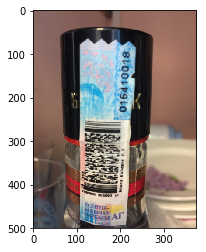

In [32]:
%lprun

excise_src = cv2.imread("test_data/IMG_0307.JPG")
resized, number = excise_number_recognition(excise_src)

# excise_src = cv2.imread("test_data/IMG_0322.JPG")
# resized, number = excise_number_recognition(excise_src)

plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))

print("Excise Number: " + str(number))